## Estimate Fuel use with vessel speed, h_0, current speed as input

### Imports
Import the required libraries

In [1]:
# package(s) related to time, space and id
import logging
import datetime, time
import platform
import itertools
# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt

# OpenTNSim
import opentnsim

# Used for mathematical functions
import math             
import tqdm
# Used for making the graph to visualize our problem
import networkx as nx   

import plotly.express as px
from plotly.subplots import make_subplots

#logging.basicConfig(level=logging.DEBUG) #turn on all the debug messages
logging.basicConfig(level=logging.INFO)# turn off all the debug messages



### create graph with navigation info

In [2]:
# specify a number of coordinate along your route (coords are: lon, lat)
coords = [
    [0,0],
    [0.4366,0],
    [0.8528,0], 
    [1.1443,0],
    [1.31495,0],
    [1.56274,0],
    [1.736384,0],
    [2.0710,0], 
    [2.20665,0],
    [3.05674,0],
    [3.32804,0],
    [4.1148,0],
    [4.54888,0], 
    [4.73879,0],
    [5.07844,0],
    [6.62475,0], 
] 

# for each edge (between above coordinates) specify the depth (m)
depths = [7.5, 4.18, 4.18, 7.83, 7.5, 6.5, 10.6, 6.45, 8.04, 5.65, 8.87, 4.93, 7.7, 9.8, 5.45]
current_speeds = [-2.24* 0.2777,-3.4* 0.2777,-4.93* 0.2777,-2.59* 0.2777,-3.26* 0.2777,
                     -3.85* 0.2777,-1.87* 0.2777,-1.08* 0.2777,-2.83* 0.2777,-4.99* 0.2777,
                     -2.89* 0.2777,-6.4* 0.2777,-3.42* 0.2777,-1.64* 0.2777,-4.1* 0.2777]  # [m/s]

V_g_profile_up = [3.415397,2.863194,2.438194,3.320490,3.132064,2.872624,3.547187,
 3.640059,3.267982,2.632721,3.249935,2.159004,3.089184,2.908767,2.832864] # [m/s] for upstream

V_g_profile_down = [4.44, 4.44, 4.44, 4.44,4.44, 4.44, 4.44, 4.44, 4.44, 4.44,4.44, 4.44, 4.44, 3.33, 4.44] # [m/s] for downstream

# power_applied = [620, 620, 620, 620, 620, 620, 620, 620, 620,620, 620, 620,620, 250, 620] ## [kW] for upstream
# check of nr of coords and nr of depths align
assert len(coords) == len(depths) + 1, 'nr of depths does not correspond to nr of coords'

In [3]:
# create a graph based on coords and depths
FG = nx.DiGraph()
nodes = []
path = []

# add nodes
Node = type('Site', (opentnsim.core.Identifiable, opentnsim.core.Locatable), {})

for index, coord in enumerate(coords):
    data_node = {"name": "Node " + str(index), "geometry": shapely.geometry.Point(coord[0], coord[1])}
    nodes.append(Node(**data_node))
    
positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry)

# add edges
path = [[nodes[i], nodes[i+1]] for i in range(len(nodes)-1)]

for index, edge in enumerate(path):
    # For the energy consumption calculation we add info to the graph. We need depth info for resistance.
    # NB: the CalculateEnergy routine expects the graph to have "Info" that contains "GeneralDepth" 
    #     this may not be very generic!
    FG.add_edge(edge[0].name, edge[1].name, weight = 1, Info = {
        "GeneralDepth": depths[index],
        "CurrentSpeed": current_speeds[index],
        "VesselSpeedToGroundProfile_upstream": V_g_profile_up[index],
        "VesselSpeedToGroundProfile_downstream": V_g_profile_down[index]
    })

# toggle to undirected and back to directed to make sure all edges are two way traffic
FG = FG.to_undirected() 
FG = FG.to_directed() 

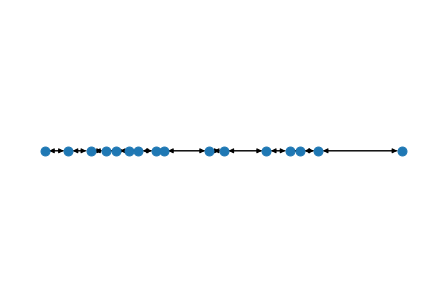

In [4]:
# show graph
nx.draw(FG, positions, node_size=80)

plt.show()

In [5]:
# This cell just shows that now a depth of 10 m is added to the edges. 
# You can use this to vary depths, e.g. make the middle edge shallower. Note that edges are bi-directional 
for edge in FG.edges:
    print('General depth for edge {} is {} m'.format(edge, FG.get_edge_data(edge[0], edge[1])["Info"]["GeneralDepth"]))
    print('Current speed for edge {} is {} m/s'.format(edge, FG.get_edge_data(edge[0], edge[1])["Info"]["CurrentSpeed"]))
    print('Vessel Speed To Ground for edge {} is {} m/s while sailing upstream'.format(edge, FG.get_edge_data(edge[0], edge[1])["Info"]["VesselSpeedToGroundProfile_upstream"]))
    print('Vessel Speed To Ground for edge {} is {} m/s while sailing downstream'.format(edge, FG.get_edge_data(edge[0], edge[1])["Info"]["VesselSpeedToGroundProfile_downstream"]))

General depth for edge ('Node 0', 'Node 1') is 7.5 m
Current speed for edge ('Node 0', 'Node 1') is -0.622048 m/s
Vessel Speed To Ground for edge ('Node 0', 'Node 1') is 3.415397 m/s while sailing upstream
Vessel Speed To Ground for edge ('Node 0', 'Node 1') is 4.44 m/s while sailing downstream
General depth for edge ('Node 1', 'Node 0') is 7.5 m
Current speed for edge ('Node 1', 'Node 0') is -0.622048 m/s
Vessel Speed To Ground for edge ('Node 1', 'Node 0') is 3.415397 m/s while sailing upstream
Vessel Speed To Ground for edge ('Node 1', 'Node 0') is 4.44 m/s while sailing downstream
General depth for edge ('Node 1', 'Node 2') is 4.18 m
Current speed for edge ('Node 1', 'Node 2') is -0.94418 m/s
Vessel Speed To Ground for edge ('Node 1', 'Node 2') is 2.863194 m/s while sailing upstream
Vessel Speed To Ground for edge ('Node 1', 'Node 2') is 4.44 m/s while sailing downstream
General depth for edge ('Node 2', 'Node 1') is 4.18 m
Current speed for edge ('Node 2', 'Node 1') is -0.94418 m/

### Create vessel - add VesselProperties and ConsumesEnergy mixins

In [6]:
# Make your preferred class out of available mix-ins.
TransportResource = type(
    "Vessel",
    (
        opentnsim.core.Identifiable,
        opentnsim.core.Movable,
        opentnsim.core.VesselProperties,  # needed to add vessel properties
        opentnsim.energy.ConsumesEnergy,
        opentnsim.core.ExtraMetadata,
    ),
    {},
)  # needed to calculate resistances

In [7]:
# Create a dict with all important settings

data_vessel_up = {
    "env": None,
    "name": 'Vessel M6',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 10.5,
    "L": 155.75,
    "H_e": None, 
    "H_f": None, 
    "T": 2,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 780.0,   
    "P_tot_given": None, # kW
    "P_tot_given_profile":False,
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.064,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1961,
}             



In [8]:
# Create a dict with all important settings

data_vessel_down = {
    "env": None,
    "name": 'Vessel M6',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 20,
    "L": 85,
    "H_e": None, 
    "H_f": None, 
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 780.0,   
    "P_tot_given": None, # kW
    "P_tot_given_profile":False,
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.064,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1961,
}             



### define sailing paths

In [9]:
path_upstream = nx.dijkstra_path(FG, nodes[0].name, nodes[15].name)
path_downstream = nx.dijkstra_path(FG, nodes[15].name, nodes[0].name)

### define simulation "Herso 1 sailing upstream and downstream"

In [10]:
def run_simulation(path,**data_vessel):
    
    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())

    # Add graph to environment
    env.FG = FG

    # Add environment and path to the vessel
    # create a fresh instance of vessel
    vessel = TransportResource(**data_vessel)
    vessel.env = env                                        #the created environment
    vessel.name = 'Vessel No.1'                     
    vessel.route = path                                     #the route (the sequence of nodes, as stored as the second column in the path)
    vessel.geometry = env.FG.nodes[path[0]]['geometry']     #a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)
    # vessel.V_g_ave = V_g_ave
    # vessel.sailing_upstream = sailing_upstream
    # vessel.P_tot_given = P_tot_given
    # Start the simulation
    env.process(vessel.move())
    env.run()
    
    return vessel

### run simulation to get energy consumption

### upstream energy consumption

In [11]:
vessel_upstream = run_simulation(path = path_upstream, **data_vessel_up)
# create an EnergyCalculation object and perform energy consumption calculation
energycalculation_upstream = opentnsim.energy.EnergyCalculation(FG, vessel_upstream)
energycalculation_upstream.calculate_energy_consumption()

# create dataframe from energy calculation computation
df_upstream = pd.DataFrame.from_dict(energycalculation_upstream.energy_use)
selected = ['edge_start','edge_stop','P_tot','P_installed','total_energy','total_diesel_consumption_ICE_mass','total_diesel_consumption_ICE_vol',
            'total_emission_CO2','total_emission_PM10','total_emission_NOX',
            'total_LH2_consumption_PEMFC_mass','total_LH2_consumption_SOFC_mass','total_LH2_consumption_PEMFC_vol','total_LH2_consumption_SOFC_vol',
           'total_eLNG_consumption_PEMFC_mass','total_eLNG_consumption_SOFC_mass','total_eLNG_consumption_PEMFC_vol','total_eLNG_consumption_SOFC_vol',
            'total_eLNG_consumption_ICE_mass','total_eLNG_consumption_ICE_vol',
            'total_eMethanol_consumption_PEMFC_mass','total_eMethanol_consumption_SOFC_mass','total_eMethanol_consumption_PEMFC_vol','total_eMethanol_consumption_SOFC_vol',
            'total_eMethanol_consumption_ICE_mass','total_eMethanol_consumption_ICE_vol','total_eNH3_consumption_PEMFC_mass','total_eNH3_consumption_SOFC_mass',
            'total_eNH3_consumption_PEMFC_vol','total_eNH3_consumption_SOFC_vol','total_eNH3_consumption_ICE_mass','total_eNH3_consumption_ICE_vol',
            'total_Li_NMC_Battery_mass','total_Li_NMC_Battery_vol','total_Battery2000kWh_consumption_num']
df_upstream = df_upstream[selected]
df_upstream

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.



,edge_start,edge_stop,P_tot,P_installed,total_energy,total_diesel_consumption_ICE_mass,total_diesel_consumption_ICE_vol,total_emission_CO2,total_emission_PM10,total_emission_NOX,total_LH2_consumption_PEMFC_mass,total_LH2_consumption_SOFC_mass,total_LH2_consumption_PEMFC_vol,total_LH2_consumption_SOFC_vol,total_eLNG_consumption_PEMFC_mass,total_eLNG_consumption_SOFC_mass,total_eLNG_consumption_PEMFC_vol,total_eLNG_consumption_SOFC_vol,total_eLNG_consumption_ICE_mass,total_eLNG_consumption_ICE_vol,total_eMethanol_consumption_PEMFC_mass,total_eMethanol_consumption_SOFC_mass,total_eMethanol_consumption_PEMFC_vol,total_eMethanol_consumption_SOFC_vol,total_eMethanol_consumption_ICE_mass,total_eMethanol_consumption_ICE_vol,total_eNH3_consumption_PEMFC_mass,total_eNH3_consumption_SOFC_mass,total_eNH3_consumption_PEMFC_vol,total_eNH3_consumption_SOFC_vol,total_eNH3_consumption_ICE_mass,total_eNH3_consumption_ICE_vol,total_Li_NMC_Battery_mass,total_Li_NMC_Battery_vol,total_Battery2000kWh_consumption_num
0,POINT (0 0),POINT (0.4366 0),619.912578,780.0,2711.690370,6.114848e+05,0.717621,2.050038e+06,1594.473937,28438.361971,215342.778761,197246.746932,2.805522,2.569764,5.391665e+05,4.938584e+05,1.271664,1.164802,5.365434e+05,1.265477,1.310953e+06,1.200789e+06,1.654954,1.515882,1.304575e+06,1.646902,1.403310e+06,1.285385e+06,2.284458,2.092487,1.396483e+06,2.273344,3.081466e+07,24.385705,1.694806
1,POINT (0.4366 0),POINT (0.8528 0),619.817631,780.0,2437.310395,5.496122e+05,0.645010,1.842607e+06,1433.138513,25561.492500,193553.511550,177288.510579,2.521648,2.309745,4.846114e+05,4.438878e+05,1.142992,1.046942,4.822537e+05,1.137431,1.178306e+06,1.079288e+06,1.487499,1.362499,1.172573e+06,1.480262,1.261317e+06,1.155324e+06,2.053307,1.880761,1.255181e+06,2.043318,2.769671e+07,21.918259,1.523319
2,POINT (0.8528 0),POINT (1.1443 0),619.735628,780.0,1706.775060,3.848769e+05,0.451681,1.290322e+06,1003.583735,17900.330887,135539.694442,124149.804153,1.765834,1.617445,3.393588e+05,3.108412e+05,0.800403,0.733142,3.377078e+05,0.796509,8.251320e+05,7.557931e+05,1.041651,0.954117,8.211176e+05,1.036583,8.832626e+05,8.090388e+05,1.437869,1.317040,8.789654e+05,1.430874,1.939517e+07,15.348697,1.066734
3,POINT (1.1443 0),POINT (1.31495 0),619.900505,780.0,1060.474536,2.391365e+05,0.280644,8.017187e+05,623.559027,11121.570214,84215.195013,77138.287869,1.097170,1.004971,2.108546e+05,1.931357e+05,0.497316,0.455525,2.098288e+05,0.494897,5.126812e+05,4.695987e+05,0.647211,0.592824,5.101869e+05,0.644062,5.487996e+05,5.026820e+05,0.893395,0.818320,5.461296e+05,0.889048,1.205085e+07,9.536642,0.662797
4,POINT (1.31495 0),POINT (1.56274 0),619.873005,780.0,1538.877041,3.470160e+05,0.407248,1.163391e+06,904.859700,16138.863091,122206.451679,111937.001958,1.592126,1.458334,3.059756e+05,2.802633e+05,0.721666,0.661022,3.044869e+05,0.718155,7.439625e+05,6.814446e+05,0.939182,0.860259,7.403430e+05,0.934613,7.963747e+05,7.294525e+05,1.296424,1.187481,7.925003e+05,1.290117,1.748724e+07,13.838822,0.961798
5,POINT (1.56274 0),POINT (1.736384 0),619.839961,780.0,1052.809566,2.374080e+05,0.278615,7.959240e+05,619.052025,11041.361492,83606.498722,76580.742527,1.089240,0.997707,2.093306e+05,1.917398e+05,0.493722,0.452232,2.083121e+05,0.491320,5.089756e+05,4.662045e+05,0.642533,0.588539,5.064994e+05,0.639407,5.448330e+05,4.990487e+05,0.886937,0.812405,5.421823e+05,0.882622,1.196375e+07,9.467712,0.658006
6,POINT (1.736384 0),POINT (2.071 0),619.928921,780.0,2093.279315,4.720334e+05,0.553965,1.582519e+06,1230.848237,21952.793223,166233.058680,152263.894085,2.165712,1.983720,4.162076e+05,3.812322e+05,0.981656,0.899164,4.141827e+05,0.976881,1.011986e+06,9.269447e+05,1.277535,1.170179,1.007062e+06,1.271320,1.083280e+06,9.922481e+05,1.763479,1.615288,1.078010e+06,1.754900,2.378726e+07,18.824454,1.308300
7,POINT (2.071 0),POINT (2.20665 0),619.954316,780.0,822.227980,1.854120e+05,0.217594,6.216044e+05,483.470052,8622.872096,65295.381816,59808.374940,0.850679,0.779194,1.634839e+05,1.497458e+05

#### upstream_total_diesel_use [kg]

In [12]:
upstream_total_diesel_use = (df_upstream['total_diesel_consumption_ICE_mass']/1000).sum() #kg
upstream_total_diesel_use

8930.074699177832

### downstream energy consumption

In [13]:
vessel_downstream = run_simulation(path = path_downstream, **data_vessel_down)
# create an EnergyCalculation object and perform energy consumption calculation
energycalculation_downstream = opentnsim.energy.EnergyCalculation(FG, vessel_downstream)
energycalculation_downstream.calculate_energy_consumption()

# create dataframe from energy calculation computation
df_downstream = pd.DataFrame.from_dict(energycalculation_downstream.energy_use)
selected = ['edge_start','edge_stop','P_tot','P_installed','total_energy','total_diesel_consumption_ICE_mass','total_diesel_consumption_ICE_vol',
            'total_emission_CO2','total_emission_PM10','total_emission_NOX',
            'total_LH2_consumption_PEMFC_mass','total_LH2_consumption_SOFC_mass','total_LH2_consumption_PEMFC_vol','total_LH2_consumption_SOFC_vol',
           'total_eLNG_consumption_PEMFC_mass','total_eLNG_consumption_SOFC_mass','total_eLNG_consumption_PEMFC_vol','total_eLNG_consumption_SOFC_vol',
            'total_eLNG_consumption_ICE_mass','total_eLNG_consumption_ICE_vol',
            'total_eMethanol_consumption_PEMFC_mass','total_eMethanol_consumption_SOFC_mass','total_eMethanol_consumption_PEMFC_vol','total_eMethanol_consumption_SOFC_vol',
            'total_eMethanol_consumption_ICE_mass','total_eMethanol_consumption_ICE_vol','total_eNH3_consumption_PEMFC_mass','total_eNH3_consumption_SOFC_mass',
            'total_eNH3_consumption_PEMFC_vol','total_eNH3_consumption_SOFC_vol','total_eNH3_consumption_ICE_mass','total_eNH3_consumption_ICE_vol',
            'total_Li_NMC_Battery_mass','total_Li_NMC_Battery_vol','total_Battery2000kWh_consumption_num']
df_downstream = df_downstream[selected]
df_downstream

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.



,edge_start,edge_stop,P_tot,P_installed,total_energy,total_diesel_consumption_ICE_mass,total_diesel_consumption_ICE_vol,total_emission_CO2,total_emission_PM10,total_emission_NOX,total_LH2_consumption_PEMFC_mass,total_LH2_consumption_SOFC_mass,total_LH2_consumption_PEMFC_vol,total_LH2_consumption_SOFC_vol,total_eLNG_consumption_PEMFC_mass,total_eLNG_consumption_SOFC_mass,total_eLNG_consumption_PEMFC_vol,total_eLNG_consumption_SOFC_vol,total_eLNG_consumption_ICE_mass,total_eLNG_consumption_ICE_vol,total_eMethanol_consumption_PEMFC_mass,total_eMethanol_consumption_SOFC_mass,total_eMethanol_consumption_PEMFC_vol,total_eMethanol_consumption_SOFC_vol,total_eMethanol_consumption_ICE_mass,total_eMethanol_consumption_ICE_vol,total_eNH3_consumption_PEMFC_mass,total_eNH3_consumption_SOFC_mass,total_eNH3_consumption_PEMFC_vol,total_eNH3_consumption_SOFC_vol,total_eNH3_consumption_ICE_mass,total_eNH3_consumption_ICE_vol,total_Li_NMC_Battery_mass,total_Li_NMC_Battery_vol,total_Battery2000kWh_consumption_num
0,POINT (6.62475 0),POINT (5.07844 0),318.892107,780.0,4039.817326,971525.312914,1.140155,3.257095e+06,2488.040076,44425.524379,288462.098033,280374.375658,3.758133,3.652765,722239.689059,701989.978151,1.703456,1.655695,852458.676820,2.010587,1.756086e+06,1.706849e+06,2.216891,2.154735,2.072706e+06,2.616594,1.879802e+06,1.827097e+06,3.060143,2.974344,2.218728e+06,3.611883,4.590702e+07,36.329293,2.524886
1,POINT (5.07844 0),POINT (4.73879 0),214.124685,780.0,518.789104,131047.591193,0.153794,4.393446e+05,342.520630,5884.146834,35129.874180,35679.167860,0.457678,0.464834,87956.752646,89332.051861,0.207453,0.210696,114986.871371,0.271205,2.138619e+05,2.172059e+05,0.269980,0.274202,2.795842e+05,0.352948,2.289285e+05,2.325081e+05,0.372674,0.378502,2.992809e+05,0.487201,5.895331e+06,4.665370,0.324243
2,POINT (4.73879 0),POINT (4.54888 0),343.022916,780.0,564.220413,134113.460827,0.157392,4.496231e+05,343.302442,6166.980111,40288.010798,39158.440402,0.524879,0.510163,100871.485682,98043.313186,0.237913,0.231242,117676.999086,0.277550,2.452634e+05,2.383868e+05,0.309622,0.300941,2.861251e+05,0.361206,2.625422e+05,2.551812e+05,0.427394,0.415411,3.062826e+05,0.498600,6.411596e+06,5.073925,0.352638
3,POINT (4.54888 0),POINT (4.1148 0),197.072015,780.0,565.248650,143898.064693,0.168875,4.824266e+05,379.126352,6464.479883,37781.086190,39863.978472,0.492218,0.519355,94594.749633,99809.810762,0.223109,0.235409,126262.437216,0.297799,2.300019e+05,2.426820e+05,0.290355,0.306363,3.070001e+05,0.387558,2.462055e+05,2.597790e+05,0.400800,0.422896,3.286283e+05,0.534976,6.423280e+06,5.083171,0.353280
4,POINT (4.1148 0),POINT (3.32804 0),376.622787,780.0,2674.636941,629323.178903,0.738556,2.109842e+06,1620.829986,28985.159788,190981.750211,185627.121700,2.488143,2.418382,478172.352031,464765.650572,1.127805,1.096184,552195.601338,1.302394,1.162649e+06,1.130052e+06,1.467734,1.426583,1.342633e+06,1.694946,1.244558e+06,1.209664e+06,2.026025,1.969221,1.437221e+06,2.339663,3.039360e+07,24.052490,1.671648
5,POINT (3.32804 0),POINT (3.05674 0),265.927383,780.0,546.815195,134851.362527,0.158258,4.520970e+05,346.278534,6093.481995,37585.562299,36490.837183,0.489671,0.475409,94105.204854,91364.276557,0.221954,0.215489,118324.466217,0.279077,2.288116e+05,2.221471e+05,0.288853,0.280440,2.876993e+05,0.363193,2.449314e+05,2.377974e+05,0.398725,0.387112,3.079678e+05,0.501343,6.213809e+06,4.917403,0.341759
6,POINT (3.05674 0),POINT (2.20665 0),381.268076,780.0,2938.976730,690731.077377,0.810623,2.315716e+06,1781.019898,31812.015239,209856.863611,203973.026313,2.734051,2.657395,525431.094605,510699.381672,1.239268,1.204522,606077.569398,1.429479,1.277556e+06,1.241737e+06,1.612793,1.567575,1.473644e+06,1.860335,1.367560e+06,1.329218e+06,2.226261,2.163843,1.577462e+06,2.567962,3.339746e+07,26.429647,1.836860
7,POINT (2.20665 0),POINT (2.071 0),579.482095,780.0,807.585052,182367.668265,0.214022,6.113981e+05,475.545576,8547.480190,64132.546669,58743.257033,0.835530,0.765317,160572.4

#### downstream_total_diesel_use [kg]

In [14]:
downstream_total_diesel_use = (df_downstream['total_diesel_consumption_ICE_mass']/1000).sum() #kg
downstream_total_diesel_use

4691.117245082922

#### roundtrip_total_diesel_use [kg]

In [15]:
roundtrip_total_diesel_use = upstream_total_diesel_use + downstream_total_diesel_use
roundtrip_total_diesel_use

13621.191944260754